In [0]:
try:
  import tflearn  # try to import tflearn
except ImportError:
  !pip3 install -q tflearn # install tflearn first
  import tflearn # then import it 

In [0]:
import matplotlib.pyplot as plt # used for plotting images
import numpy as np # to do math functions
import os, sys  # to interact with filesystem
import tensorflow as tf  # tensorflow during training
from tflearn.activations import relu # rectified linear activation function

# normalizes data 
from tflearn.layers.normalization import batch_normalization as bn
from scipy.misc import imread, bytescale, imresize  # image manipulation functions
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.estimator import regression  # trainer for the network

# turns scalar label into vector where appropriate class is value 1 and others 0
from tflearn.data_utils import to_categorical  

# makes new images from the ones we have by flipping them, rotating, etc.
from tflearn.data_augmentation import ImageAugmentation

# to visualize the data space
from tensorflow.contrib.tensorboard.plugins import projector

In [3]:
# import dataset loader from tflearn
import tflearn.datasets.oxflower17 as oxflower17

# load the data in as X and the labels in as Y
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(150, 150))

100.0% 60276736 / 60270631


('Succesfully downloaded', '17flowers.tgz', 60270631, 'bytes.')
File Extracted
Starting to parse images...
Parsing Done!


In [0]:
tf.reset_default_graph()

In [6]:
# tflearn documentation --- http://tflearn.org/

# create input layer that takes in images and augments them as well
in_layer = input_data(shape=[None, 150, 150, 3])

# have 64, 7x7 filters slide over the input images
conv1 = conv_2d(in_layer, 64, 7, activation='linear', name='c1')

# normalize conv1 layer feature maps
batch_norm1 = bn(conv1, name='bn1')

# perform relu activation function
relu1 = relu(batch_norm1)

# max pooling 
pool1 = max_pool_2d(relu1, 3, 2)

# second conv layer with 128, 3x3 filters
conv2 = conv_2d(pool1, 128, 3, activation='linear', name='c2')

# second normalization layer
batch_norm2 = bn(conv2, name='bn2')

# second relu layer
relu2 = relu(batch_norm2)

# max pooling layer 2
pool2 = max_pool_2d(relu2, 3, 2)

# conv3 layer
conv3 = conv_2d(pool2, 256, 3, activation='linear', name='c3')

# normalize c3 layer
batch_norm3 = bn(conv3, name='bn3')

# relu on normalized c3 heat maps --- num_images x 37 x 37 x 256
relu3 = relu(batch_norm3)

# take the average of each of the 256 feature maps --- num_images x 1 x 1 x 256
gap = global_avg_pool(relu3)

# output layer --- softmax turns output values into probabilities
out_layer = fully_connected(gap, 17, activation='softmax', name='fc')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [7]:
# describe how to optimize the network's weights
network = regression(out_layer, optimizer='adam', 
                     loss='categorical_crossentropy', learning_rate=.001)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# build the network based on the description above
model = tflearn.DNN(network, tensorboard_verbose=2)

In [0]:
# skip if already saved and want to test it later
model.fit(X, # input data
          Y, # corresponding labels
          n_epoch=50, # number of times to go through entire dataset
          shuffle=True,   # shuffle the images each epoch
          validation_set=0.1,  # use 10% for validation
          show_metric=True, # show validation accuracy/loss in tensorboard
          batch_size=50,   # go through dataset 50 examples at a time
          run_id='OxfordFlowers_CNN')  # name that will show up on tensorboard
model.save('flower_model_run1') # save the trained model

In [0]:
#model.load('flower_model_run1') # load the saved model

In [0]:
num_classes = 17
conf_mat = np.zeros([num_classes, num_classes])

In [0]:
for val_sample in range(X.shape[0]): # loop through validation samples
  x = X[val_sample, ...]  # that sample
  y = Y[val_sample, ...] # that sample's label
  
  y = np.argmax(y)  # get the position of the 1 in the label vector
  
  output = model.predict(x[None, ...]) # have the model predict on the sample
  
  output = np.argmax(output) # get the class based on highest value in the output vector
  
  conf_mat[y, output] += 1

In [12]:
conf_mat

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0., 69.,
         0.,  0.,  0.,  6.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 31.,  6., 43.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 56.,  3., 21.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  2., 65.,
         0.,  0.,  0.,  9.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 55.,
         0.,  0.,  0., 24.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  2., 75.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0., 58.,
         0.,  0.,  0., 18.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.,  2., 54.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 33.,  1., 46.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 17.,  1., 61.,
         

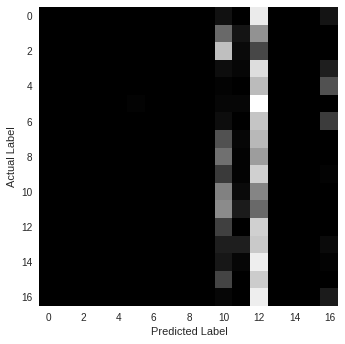

In [15]:
plt.imshow(conf_mat, cmap='gray')
plt.grid(False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()